!conda update pandas -y
!pip install pykalman
!pip install numdifftools

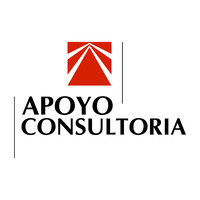

# Kalman

Esta libreria construye la estimacion de Kalman especificada en el punto XX.XX del informe. Se busca llevar la información trimestral a frecuencia mensual mediante el uso de un modelo espacio estado.

Esta libreria realiza la estimacion, sin embargo no realiza la interpolacion ni la evaluacion, la cual se realiza con el siguiente modulo.


# Librerias importadas


In [1]:
import pykalman as kalman
import pandas as pd
import datetime as dt
import numpy as np
import matplotlib.pyplot as plt
import os

from ipynb.fs.defs.ConstruccionBasedeDatos import BasedeDatos

import numdifftools

from statsmodels.tsa.arima_model import ARIMA
import statsmodels.api as sm

import seaborn as sns

In [2]:
rutaOrigen = 'inputs/'
rutaDestino = 'resultados/'
rutaModelos = 'model_interpol/'

# Construccion de Base de datos

In [3]:
bd_mensual_t,bd_trimestral_t,bd_anual_t,bd_all = BasedeDatos(rutaOrigen + 'bd_Panama.xlsx')

C:\Users\Usuario\Anaconda3\lib\site-packages\pandas\core\series.py:853: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
C:\Users\Usuario\Anaconda3\lib\site-packages\pandas\core\series.py:853: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


# Especificacion de variables a estimar 

In [4]:
VariablesPBI = ['pbif_Trimestre_VariacionAnual']

#Seleccion de variables

var_sel = {'pbif_Trimestre_VariacionAnual': 
['imae_com_car_Mensual_VariacionAnual',
'imae_com_imp_vl_Mensual_VariacionAnual'
#'fisr_zlc_Mensual_VariacionAnual',
#'fisi_des_Mensual_VariacionAnual',
#'ipc1_viv_Mensual_VariacionAnual',
#'ipc1_trp_Mensual_VariacionAnual'
]
          }

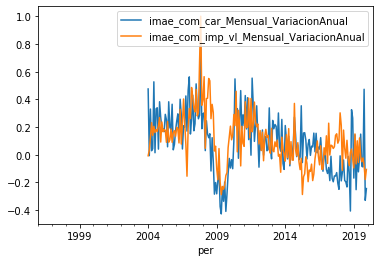

In [5]:
bd_all[var_sel[VariablesPBI[0]]].plot()

#  Filtro de Kalman

Se estima un filtro de Kalman para interpolar el PBI a frecuencia mensual. El PBI trimestral es observado cada tres meses, y las contribuciones de cada mes sumadas generan esta variable.

##### Ecuacion normal:

$$\Delta y_t^T = \Delta y_t^m  + \Delta y_{t-1}^m + \Delta y_{t-2}^m$$
##### Ecuaciones de transicion:
$$\Delta y_{t-1}^m = \phi \Delta y_{t-1}^m + \beta X_t + \epsilon_t$$
$$\epsilon_t = \rho \epsilon_t + \eta_t$$

$X_t$ son las variables usadas para interpolar. Para el caso especifico estan compuestas por la producción de electricidad en la zona.



El programa interpol esta generalizado, pued estimar un filtro de kalman para variables con periodicidad ___frq_1___ (alta frecuencia) para cada frecuencia ___frq_2___ (baja frecuencia).

La base ___bd_all___ contiene todas las variables que se usaran en dicho filtro. Los parámetros del modelo son usados de la variable ___params___ y estan ordenados de la siguiente forma: $\phi,\rho,\sigma_e^2.\beta$

La estimación deja libre ___test_size___ observaciones para realizar la evaluación.

In [6]:
def interpol(bd_all, X, y, frq_1, frq_2, params, test_size):
    import numpy as numpy
    from pykalman import KalmanFilter

    bd = bd_all[~(bd_all[X].isna().sum(axis = 1) >0)]
    bd = bd[X].join(bd[y])
    
    #Fijando base de referencia para y en caso se haga un ejercicio de train test
    bd[y[0] + '_data'] = bd[y]
    
    #No se recibe informacion test_size periodos
    if test_size>0:
        bd.loc[-test_size:,y] = 0
    
    bd = bd.fillna(0)

    #Parametros
    phi = params[0]
    rho = params[1]
    var_e = params[2]
    beta = params[3:]
    
    if len(beta) != len(X):
        display('Dimensiones de parametros no consistentes')
    
    frq = int(frq_1/frq_2)
    bd[y] == 0
    
    ##########################################
    #Frecuencia maxima de no observables
    bd['ID_aux'] = 0
    bd.loc[bd[y[0]] != 0,'ID_aux'] = 1
    bd['ID'] = bd['ID_aux'].cumsum()
    bd = bd.drop(['ID_aux'], axis = 1)
    frq_aux = int(bd.groupby(['ID'])[y].count().max())
    bd = bd.drop(['ID'], axis = 1)
    
    frq = min(frq_aux,frq)
    
    ##########################################
    #Creando dos variables de prueba para la interpolacion

    n_ss = frq + 2
    n_qq = bd.shape[0]

    ###############################################
    #Observables

    #Matriz de observables

    H = []
    i = 0
    for date in bd.index:
        i += 1
        if (bd.loc[date,y].values != 0):
            if i>frq:
                i = frq
            aux = [1] * i + [0] * (frq + 2 - i)
            i = 0
        else:
            aux = [0] * (frq + 2)
        H.append([aux])


    observation_offset = [0]
    observation_matrix = np.array(H)
    observation_covariance =  np.zeros([1,1])

    ###############################################
    #Transicion

    #Interceptos
    X_beta = np.matmul(bd[X].values,beta)
    transition_offset = np.zeros([n_qq,n_ss])
    transition_offset[:,0] = X_beta
    transition_offset = transition_offset.tolist()

    #Matriz de transicion
    transition_matrix = np.zeros([n_ss,n_ss])
    transition_matrix[0,0] = phi
    transition_matrix[0,n_ss-1] = 1
    transition_matrix[n_ss-1,n_ss-1] = rho

    for i in range(frq):
        transition_matrix[i+1,i] = 1

    #Varianzas 

    transition_covariance = np.zeros([n_ss, n_ss])
    transition_covariance[n_ss-1,n_ss-1] = var_e

    ###############################################
    #Estados iniciales
    initial_state_mean = np.ones(n_ss) * 0.002
    initial_state_covariance = np.eye(n_ss) * 0.01**2


    # Creando filtro
    kf = KalmanFilter(
        transition_matrix, observation_matrix, 
        transition_covariance, observation_covariance,
        transition_offset,observation_offset,
        initial_state_mean, initial_state_covariance
        #,random_state=random_state
    )
    
    ll = kf.loglikelihood(bd[y])
    
    return ll, kf, bd

def t_params(x):
    #Si no es lista volver lista
    if type(x) != list:
        x = x.tolist()
    
    #Transformacion de beta
    phi = x[0] / (1 + abs(x[0])) * 0.9
    #Transformacion de rho
    rho = x[1] / (1 + abs(x[1])) * 0.9
    #Transformacion de sigma
    sigma = x[2] ** 2
    #Betas
    beta = np.abs(x[3:])
    beta = beta.tolist()
    
    params = [phi,rho,sigma] + beta

    return params

# Estimacion y Resultados

La estimacion del modelo se realiza usando el método de máxima verosimilitud, se busca maximizar la probabilidad de la ocurrencia de las variables, dados los parametros. Los resultados se guardan en un excel que luego será usado como insumo para la interpolación final del modelo.

Para asegurar que el maximo hallado es uno global se usan distintos puntos iniciales para realizar la estimación.

In [7]:
bd_all[VariablesPBI+ var_sel[VariablesPBI[0]]].dropna(how='all')

,pbif_Trimestre_VariacionAnual,imae_com_car_Mensual_VariacionAnual,imae_com_imp_vl_Mensual_VariacionAnual
per,,,
1997-03-01,0.046668,NaN,NaN
1997-06-01,0.062669,NaN,NaN
1997-09-01,0.071789,NaN,NaN
1997-12-01,0.075823,NaN,NaN
1998-03-01,0.090917,NaN,NaN
...,...,...,...
2019-08-01,NaN,-0.083352,-0.050265
2019-09-01,0.033609,-0.087550,-0.022842
2019-10-01,NaN,0.473145,-0.077249


In [ ]:
from numdifftools import Jacobian, Hessian
from scipy.optimize import minimize
np.random.seed(0)
n_i = 3
test_size = 0
frq1 = 3
frq2 = 1
max_iter = 1000
replace = 1
for varpbi in VariablesPBI:
    X = var_sel[varpbi]
    y = [varpbi]
    
    display(y)
    display(X)
    
    z_min = lambda params: -interpol(bd_all,X,y,frq1,frq2,t_params(params),test_size)[0]
    z_hess = lambda params: -interpol(bd_all,X,y,frq1,frq2,params,test_size)[0]
    
    LogLikelihood = np.Inf
    
    for i in range(n_i):
    
        x0 = [np.random.normal()*4,np.random.normal()*4,np.random.normal()*0.01] + np.random.normal(size = len(X)).tolist()
        print(x0)
        x_opt_ = minimize(z_min, x0, method='Nelder-Mead', options={'disp': False,'maxiter':max_iter})
        x_opt_ = minimize(z_min, x_opt_.x, method='Nelder-Mead', options={'disp': True,'maxiter':max_iter})

        if x_opt_.fun < LogLikelihood:
            x_opt = x_opt_
            LogLikelihood = x_opt.fun
    
    ParametrosOptimizados = t_params(x_opt.x)
    JacobianoParametros = Jacobian(z_hess, step = 0.0000001)(ParametrosOptimizados)
    HessianoParamatros = Hessian(z_hess, step = 0.0000001)(ParametrosOptimizados)
    VarianzaParametros = np.diag(np.linalg.inv(HessianoParamatros))

    ResultadosEstimacion = pd.DataFrame({'Valor': ParametrosOptimizados,'STD': VarianzaParametros**0.5})
    ResultadosEstimacion['T'] = ResultadosEstimacion['Valor'] /ResultadosEstimacion['STD']
    ResultadosEstimacion.index = ['Phi','Rho','Sigma^2'] + X

    if replace == 1:
        
        with pd.ExcelWriter(rutaModelos + 'ModelosKalman.xlsx') as writer:
            ResultadosEstimacion.to_excel(writer, sheet_name=varpbi[0:20])
        replace = 0
    else:
    
        with pd.ExcelWriter(rutaModelos + 'ModelosKalman.xlsx', engine="openpyxl", mode="a") as writer:
            ResultadosEstimacion.to_excel(writer, sheet_name=varpbi[0:20])
    

['pbif_Trimestre_VariacionAnual']

['imae_com_car_Mensual_VariacionAnual',
 'imae_com_imp_vl_Mensual_VariacionAnual']

[7.056209383870656, 1.6006288334688932, 0.009787379841057393, 2.240893199201458, 1.8675579901499675]


In [ ]:
with pd.ExcelWriter(rutaModelos + 'ModelosKalman.xlsx') as writer:
    ResultadosEstimacion.to_excel(writer, sheet_name=varpbi[0:20])